# Customization and Control


> **Note**
>
> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First, let's run the following code to generate a basic analysis for us to begin working with.
This code is essential the same as that found in the [tutorial](https://bursth2mm.readthedocs.io/en/latest/Tutorial.html).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)
# plot the alternation histogram
# frb.bpl.plot_alternation_hist(frbdata)  # commented to prevent plotting
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
# frb.dplot(frbdata, frb.hist_bg) # commented to prevent plotting
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)
# frb.alex_jointplot(frbdata_sel) # commented to prevent plotting
# import into burstH2MM
bdata = bhm.BurstData(frbdata_sel)
bdata.models.calc_models()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


<a id='custplot'></a>
# Caclulating Nanotimes with Confidence Threshold

By default, when calculating [H2MM_result.nanohist](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.nanohist) and [H2MM_result.dwell_nano_mean](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.dwell_nano_mean), all photons are considered. 
However, not every photon is necessarily the best way to do this, as we can be more confident of some photon state assignments than others. 
This comes by way of the [H2MM_result.scale](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.scale) parameter, which is a measure of the likelihood of the photon being in the state assigned by the *Viterbi* algorithm (it is one of the outputs of the *Viterbi* algorithm itself). 
Now, it does not make sense to use this for calculating dwell duration, or even E/S values, as these are very much dependent on taking the whole dwell. 
However, for nanotime parameters, some filtration could be useful (although in our tests, it has never made a significant difference, but we still wanted to provide the option).

> **Note**
> 
> The `scale` parameter is a likelihood parameter, therefore it is contained within the interval (0,1). 
> Therefore confidence thresholds must also fall within the interval \[0,1). 
> Setting to 0 will result in all photons being considered.

This can be done in two ways: 
1. Using functions, without changing the stored parameter values 
2. Using [H2MM_result.conf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.conf_thresh), which will change stored parameters [H2MM_result.nanohist](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.nanohist) and [H2MM_result.dwell_nano_mean](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.dwell_nano_mean)

For option 1, the appropriately named functions [calc_nanohist()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.calc_nanohist) and [calc_dwell_nanomean()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.calc_dwell_nanomean) exist. 
To set a threshold, use the keyword argument `conf_thresh` like so:

In [10]:
# set irf thresh
bdata.irf_thresh = np.array([2355, 2305, 220])
# recalculate the nanotime histogram excluding photons with a scale value less than 0.3
nanohist = bhm.calc_nanohist(bdata.models[2], conf_thresh=0.3)
# calculate mean nanotimes of DexDem stream with same threshold
dwell_nano_mean_dd = bhm.calc_dwell_nanomean(bdata.models[2], frb.Ph_sel(Dex='Dem'), 2355, conf_thresh=0.3)

> **Note**
> 
> The second argument of [calc_dwell_nanomean()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.calc_dwell_nanomean) is the desired photon stream. 
> The third argument of [calc_dwell_nanomean()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.calc_dwell_nanomean) is the threshold for the IRF. 
> You could also input `bdata.models[2].irf_thresh` and [calc_dwell_nanomean()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.calc_dwell_nanomean) will automatically choose the right threshold for the given photon stream.

Using option 2, you will only need to do the following:

In [11]:
bdata.models[2].conf_thresh = 0.3

And the [H2MM_result.nanohist](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.nanohist) and [H2MM_result.dwell_nano_mean](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.dwell_nano_mean) attributes of the [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result) attribute will be updated

> **Note**
> 
> The [H2MM_result.conf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.conf_thresh) attribute is specific to each [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result), so set each one you are interested in individually. 
> This is because the distribution of likelihoods is not comparable for models with different numbers of states.

## Customizing Photon Streams (mp vs sp H<sup>2</sup>MM)

You may have noticed that in [Control plotting functions](https://bursth2mm.readthedocs.io/en/latest/ControlPlot.html#controlplot) that when arrays are organized by photon stream, they always go in the order D<sub>ex</sub>D<sub>em</sub>, D<sub>ex</sub>A<sub>em</sub>, A<sub>ex</sub>A<sub>em</sub>. 
This is the default, but if 

1. The data does not have alternating excitation **or**
2. You have explicitly specified when creating the [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) object.

then the photon streams may not follow this pattern.

To check the order in which photon streams are specified, you can access the [BurstData.ph_streams](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.ph_streams) attribute:

In [12]:
bdata.ph_streams

(Ph_sel(Dex='Dem', Aex=None),
 Ph_sel(Dex='Aem', Aex=None),
 Ph_sel(Dex=None, Aex='Aem'))

This will always return a tuple of the actual order of photon streams for instance in the [H2MM_result.nanohist](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.nanohist) or [H2MM_result.dwell_ph_counts](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.dwell_ph_counts) arrays.

So, what if for some reason you want to create a [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) object with a different selection of photon streams? 
For instance, if you know your A<sub>ex</sub>A<sub>em</sub> stream will introduce undesirable behavior, or just want to compare, you can specify the `ph_streams` keyword argument with a list/tuple of the order of streams you want, defined using FRETBurst `Ph_sel` objects.

> **Note**
> 
> burstH2MM is smart, in calculating E and S values, it will do so correctly regardless of the order in which [BurstData.ph_streams](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.ph_streams) is specified, because it automatically identifies which stream is which for the appropriate calculations. 
> This also means that if there is no A<sub>ex</sub>A<sub>em</sub> stream, then an error will be raised if you attempt to access a stoichiometry based value.

So let’s demonstrate this, where we will perform H<sup>2</sup>MM in the original form, using only D<sub>ex</sub>D<sub>em</sub> and D<sub>ex</sub>A<sub>em</sub> streams:

The model converged after 3 iterations

The model converged after 40 iterations

The model converged after 510 iterations

Optimization reached maximum number of iterations

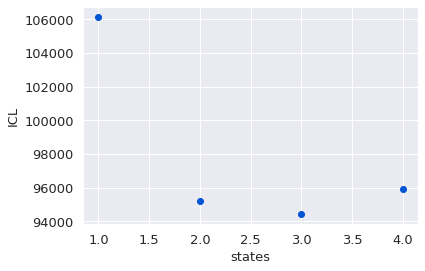

In [13]:
# make 2 stream BurstData
spdata = bhm.BurstData(frbdata_sel, ph_streams=[frb.Ph_sel(Dex='Dem'), frb.Ph_sel(Dex='Aem')])
# run optimization
spdata.models.calc_models()
# plot ICL to choose the best model
bhm.ICL_plot(spdata.models)

Great! Now we can look at the dwell FRET histogram:

[<BarContainer object of 20 artists>,
 <BarContainer object of 20 artists>,
 <BarContainer object of 20 artists>]

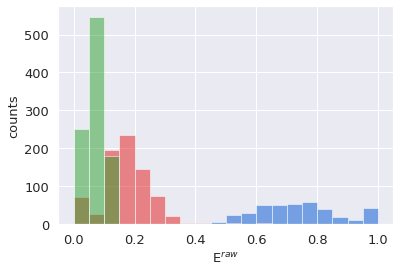

In [14]:
bhm.dwell_E_hist(spdata.models[2])

Just be aware, if you try to get a stoichiometry based value (any of them!) you will get an error:

In [15]:
try:
    bhm.dwell_ES_scatter(spdata.models[2])
except Exception as e:
    print(e)

Parent BurstData must include AexAem stream 


## Customizing divisors

There are two methods for defining new divisor schemes.

1. [BurstData.auto_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.auto_div) - high level method
2. [BurstData.new_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.new_div) - low level method

> **Note**
> 
> [BurstData.auto_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.auto_div) acutally calls [BurstData.new_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.new_div), but simplifies the specification of divisors to the end user.

So let’s see it in action:

In [16]:
name = bdata.auto_div(2)

So where are the divisors in this system? 
In all streams, there are 2 divisors (3 indices per stream), and they equally divide the nanotimes into these indices.

We can see the nanotimes of these divisors using the [H2MM_list.divisor_scheme](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_list.divisor_scheme) attribute, and compare where they are relative to the nanotime decays. 
We will use the [raw_nanotime_hist()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.raw_nanotime_hist) to plot the nanotime decays, and place vertical lines at the positions of the divisors:

[[<matplotlib.lines.Line2D at 0x7fee221f8040>,

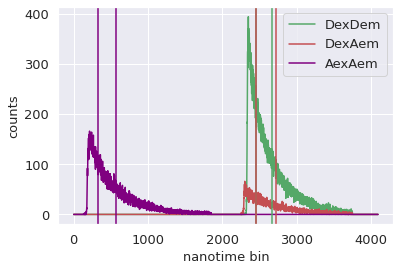

In [17]:
fig, ax = plt.subplots()
# plot histogram of nanotimes by stream
bhm.raw_nanotime_hist(bdata, ax=ax)
divs = bdata.div_models[name].divisor_scheme
# plot vertical lines of divs
bhm.axline_divs(bdata.div_models[name], ax=ax)

[BurstData.auto_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.auto_div) offers the option to add one more level of granularity:

[[<matplotlib.lines.Line2D at 0x7fee1c1a4a00>,

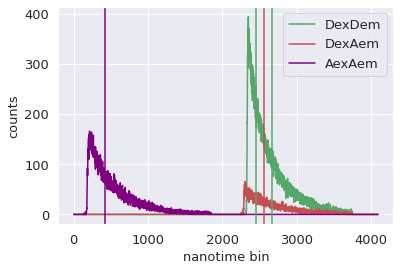

In [18]:
# make new divisor set
name211 = bdata.auto_div([2,1,1])
# now call same plotting code as before
fig, ax = plt.subplots()
# plot histogram of nanotimes by stream
bhm.raw_nanotime_hist(bdata, ax=ax)
# plot vertical lines of divs
bhm.axline_divs(bdata.div_models[name211], ax=ax)

So what will this do? 
Now, the number of divisors is specified per stream, meaning the D<sub>ex</sub>D<sub>em</sub> stream will have 2 divisors, while the D<sub>ex</sub>A<sub>em</sub> and A<sub>ex</sub>A<sub>em</sub> streams will have only 1 divisor. 
The even distribution of nanotimes between the divisors will however be maintained.

If you look at the documentation, you will notice that there is a keyword argument `include_irf_thresh`. 
This adds a divisor to the already existing divisors, which is the threshold set in [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh). 
So, if you call [BurstData.auto_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.auto_div) with `inlcude_irf_thresh=True`, there will be one extra divisor than if you had called it with `inlcude_irf_thresh=False` (the default).:

[[<matplotlib.lines.Line2D at 0x7fee1c14c100>,

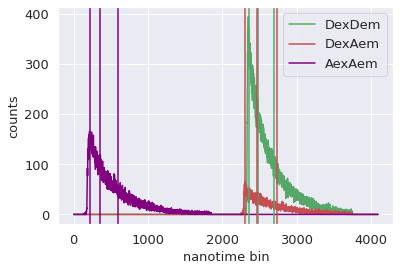

In [19]:
bdata.irf_thresh = np.array([2355, 2305, 220])
nameirf = bdata.auto_div(2, include_irf_thresh=True)
# call same plotting code as before
fig, ax = plt.subplots()
bhm.raw_nanotime_hist(bdata, ax=ax)
# plot vertical lines of divs
bhm.axline_divs(bdata.div_models[nameirf], ax=ax)

Finally, [BurstData.new_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.new_div) offers the greatest granularity, but also requires the most work by the user. 
When using [BurstData.new_div()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#BurstData.BurstData.new_div), you must specify the nanotime divisors themselves.

The function call looks like this:

[[<matplotlib.lines.Line2D at 0x7fee1c079400>],

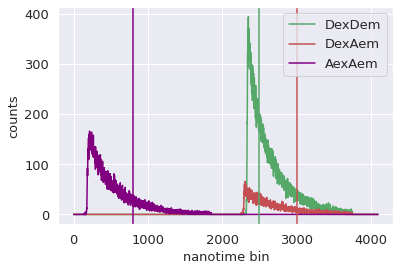

In [20]:
divs = [np.array([2500]), np.array([3000]), np.array([800])]
namecustom = bdata.new_div(divs)
# call same plotting code as before
fig, ax = plt.subplots()
bhm.raw_nanotime_hist(bdata, ax=ax)
divs = bdata.div_models[namecustom].divisor_scheme
# plot vertical lines of divs
bhm.axline_divs(bdata.div_models[namecustom], ax=ax)

## Customizing optimizations

As a wrapper around [H2MM_C](https://h2mmpythonlib.readthedocs.io), burstH2MM handles a lot of the inner details of working with [H2MM_C](https://h2mmpythonlib.readthedocs.io) automatically, however, it does allow the user to override these defaults.

[H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) automatically optimizes several H<sup>2</sup>MM models, and the initial H<sup>2</sup>MM models used in those optmizations are provided in those optimizations. 
If you have a look at the documentation, there also exists the [H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize) method, and its first argument is an `H2MM_C.h2mm_model`, this method is the actual method that makes each [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result) object, and relies on `H2MM_C.h2mm_model.optimize()` to optimize the input `H2MM_C.h2mm_model`, which is the basis of the [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result) object. 
[H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) actually calls [H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize) for each state model, and uses `H2MM_C.factory_h2mm_model()` to make the input models.

### Using [H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize)

So, if you want to control the initial models, you can use [H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize) instead like so:

> **Note**
> 
> If a given state-model has already been optimized, you must specify the keyword argument `replace=True`:

In [21]:
# we need to add H2MM_C to generate the models
import H2MM_C as h2

# make custom initial model
prior = np.array([0.75, 0.25])
trans = np.array([[1 - 1e-7, 1e-7],
                  [3e-7, 1 - 3e-7]])
obs = np.array([[0.4, 0.1, 0.5],
                [0.2, 0.3, 0.5]])
init = h2.h2mm_model(prior, trans, obs)

# now we can optimize with the custom model
bdata.models.optimize(init, replace=True)

The model converged after 34 iterations

[H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize) also allows passing the same keyword arguments as `H2MM_C.h2mm_model.optimize()`, and thus the maxiumum number of iterations and other limits can be controlled in this same way.

For instance:

In [22]:
prior = np.array([0.5, 0.25, 0.25])
trans = np.array([[1 - 2e-7, 1e-7, 1e-7],
                  [2e-7, 1 - 3e-7, 1e-7],
                  [2e-7, 1e-7, 1 - 3e-7]])
obs = np.array([[0.4, 0.1, 0.5],
                [0.2, 0.3, 0.5],
                [0.1, 0.1, 0.8]])
init = h2.h2mm_model(prior, trans, obs)
bdata.models.optimize(init, max_iter=7200, replace=True)

The model converged after 144 iterations

### Using [H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models)

[H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) functions in essentially the same way.

> **Note** 
> 
> Since we are running this notebook top to bottom, we set the `replace=True` keyword argument.

In [23]:
bdata.models.calc_models(max_iter=7200, replace=True)

The model converged after 1 iterations

The model converged after 36 iterations

The model converged after 128 iterations

The model converged after 414 iterations

2

So now all optimizations will run for a maximum of 7200 iterations instead of the default of 3600.

You can even specify initial models using [H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models), using the `models` keyword argument. 
For this, simply hand models a list of `H2MM_C.h2mm_model` objects. 
[H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) will then use those models as initial models. 
However, [H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) still obeys the other settings provided, eg. it will start optimizing the model with `min_state` number of states, and optimize at least to to_state, until `conv_crit` or `max_state` number of states is reached. 
[H2MM_list.calc_models()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.calc_models) will use the model for that number of states given to models, and if such a model does not exist within models, it will fall back on using `H2MM_C.factory_h2mm_model()` to generate the function.

> **Note**
> 
> If you are trying to bound optimizations with `bounds_func` and `bounds` keyword arguments, be aware that you must use them such that the will work for all optimizations. 
> This means that specifying arrays for the `trans`/`obs`/`prior` limits will not work. 
> If you wish to set the bounds for each state-model optimization, use [H2MM_list.optimize()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#H2MM_list.H2MM_list.optimize) instead.

So let’s see an example:

In [24]:
# setup 2 state initial model
prior2 = np.array([0.75, 0.25])
trans2 = np.array([[1 - 1e-7, 1e-7],
                  [3e-7, 1 - 3e-7]])
obs2 = np.array([[0.4, 0.1, 0.5],
                [0.2, 0.3, 0.5]])
init2 = h2.h2mm_model(prior2, trans2, obs2)

# setup 3 state initial model
prior3 = np.array([0.5, 0.25, 0.25])
trans3 = np.array([[1 - 2e-7, 1e-7, 1e-7],
                  [2e-7, 1 - 3e-7, 1e-7],
                  [2e-7, 1e-7, 1 - 3e-7]])
obs3 = np.array([[0.4, 0.1, 0.5],
                [0.2, 0.3, 0.5],
                [0.1, 0.1, 0.8]])
init3 = h2.h2mm_model(prior3, trans3, obs3)

# make model list
inits = [init2, init3]

# run optimization with some initial models
bdata.models.calc_models(models=inits)

The model converged after 31 iterations

The model converged after 141 iterations

2

If not already optimized, this will optimize even the 1 state and 4 state models, using `H2MM_C.factory_h2mm_model()` to create them. 
But when it optimizes the 2 state model, it will use `init2`, and the 3 state model will use `init3`.